<h1><center>Exploration of Quench heaters</center></h1>

# 0. Initialise the working environment
### 0.1 Install required packages for SWAN

In [1]:
import sys
if sys.version_info < (3,0):
    raise Warning("Not available for Python2. Compatible with Python3 only!")
    
!{sys.executable} -m pip install --user --upgrade tzlocal
!{sys.executable} -m pip install --user --upgrade lhcsmapi
!{sys.executable} -m pip install --user --upgrade influxdb

Requirement already up-to-date: tzlocal in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages
  Using cached https://files.pythonhosted.org/packages/3d/73/fe30c2daaaa0713420d0382b16fbb761409f532c56bdcc514bf7b6262bb6/pytz-2019.1-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: lhcsmapi in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: influxdb in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages
  Using cached https://files.pythonhosted.org/packages/51/bd/23c926cd341ea6b7dd0b2a00aba99ae0f828be89d72b2190f27c11d4b7fb/requests-2.22.0-py2.py3-none-any.whl
Requirement already up-to-date: python-dateutil>=2.6.0 in /usr/local/lib/swan (from influxdb)
R

## 0.2 Import required packages

In [2]:
# External packages
import math
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import datetime

# Internal packages
from lhcsmapi.metadata.Metadata import Metadata
from lhcsmapi.Time import Time
from lhcsmapi.dbsignal.Signal import Signal

# 1. Choose magnet type and day to analyse

In [3]:
selectedYear = 2015
selectedMonth = 1
selectedDay = 1
incrementYear = 1
incrementMonth = 0
incrementDay = 0

magnetType = 'MB'
circuitType = 'RB'
component = 'QPS'

## 1.1 Get metadata for the magnet type

In [4]:
metadata = Metadata.getMetadata(component, magnetType)[magnetType]
uNames = metadata['V_MEAS']
iNames = metadata['iNames']
print(uNames)
print(iNames)

['U_HDS_1', 'U_HDS_2', 'U_HDS_3', 'U_HDS_4']
['I_HDS_1', 'I_HDS_2', 'I_HDS_3', 'I_HDS_4']


## 1.2 Read CSV as a dataframe
<img src = "figures/acquisition.png" width=25%>

In [5]:
fileName = '{}_{}_{}_{}-{}-{}-{}_Timestamp_features.csv'.format(magnetType,\
                                                      selectedYear, selectedMonth, selectedDay,\
                                                      incrementYear, incrementMonth, incrementDay)

print("Reading timestamp and features to a file: {}".format(fileName))

data = pd.read_csv(fileName) 
data.head()

Reading timestamp and features to a file: MB_2015_1_1-1-0-0_Timestamp_features.csv


timestamp  I_HDS_4_min  I_HDS_3_min  I_HDS_2_min  I_HDS_1_min  \
0  1420114106613000000  65535.00000  65535.00000  65535.00000  65535.00000   
1  1420536812313000000  65535.00000  65535.00000  65535.00000  65535.00000   
2  1420553458913000000    125.00146    125.00146    125.00146    125.00146   
3  1420554144812000000    125.00146    125.00146    125.00146    125.00146   
4  1420554830412000000    125.00146    125.00146    125.00146    125.00146   

   U_HDS_4_min  U_HDS_3_min  U_HDS_2_min  U_HDS_1_min  I_HDS_4_max  \
0   65535.0000   65535.0000   65535.0000   65535.0000  65535.00000   
1   65535.0000   65535.0000   65535.0000   65535.0000  65535.00000   
2    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   
3    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   
4    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   

            ...             U_HDS_1_median_first  I_HDS_4_median_last  \
0           ...                     65535.000000         65535.000000   
1           ...                     65535.000000         65535.000000   
2           ...                      1256.047119           125.001457   
3           ...                      1256.047119           125.001457   
4           ...                      1256.047119           125.001457   

   I_HDS_3_median_last  I_HDS_2_median_last  I_HDS_1_median_last  \
0         65535.000000         65535.000000         65535.000000   
1         65535.000000         65535.000000         65535.000000   
2           125.001457           125.001457           125.001457   
3           125.001457           125.001457           125.001457   
4           125.001457           125.001457           125.001457   

   U_HDS_4_median_last  U_HDS_3_median_last  U_HDS_2_median_last  \
0         65535.000000         65535.000000         65535.000000   
1         65535.000000         65535.000000         65535.000000   
2          1256.047119          1256.047119          1256.047119   
3          1256.047119          1256.047119          1256.047119   
4          1256.047119          1256.047119          1256.047119   

   U_HDS_1_median_last  RPTE.UA67.RB.A67:I_MEAS  
0         65535.000000                    -0.13  
1         65535.000000                      NaN  
2          1256.047119                      NaN  
3          1256.047119                     0.02  
4          1256.047119                      NaN  

[5 rows x 75 columns]

## 1.3 Display number of events

In [6]:
print("Loaded {} events for {} in {}".format(len(data), magnetType, selectedYear))

Loaded 11896 events for MB in 2015


## 1.4 Add circuit name

In [7]:
data['circuit'] = data.apply (lambda row: Metadata.getArcNamesFromMagnetNames(circuitType, row['magnetName']), axis=1)
data.head()

timestamp  I_HDS_4_min  I_HDS_3_min  I_HDS_2_min  I_HDS_1_min  \
0  1420114106613000000  65535.00000  65535.00000  65535.00000  65535.00000   
1  1420536812313000000  65535.00000  65535.00000  65535.00000  65535.00000   
2  1420553458913000000    125.00146    125.00146    125.00146    125.00146   
3  1420554144812000000    125.00146    125.00146    125.00146    125.00146   
4  1420554830412000000    125.00146    125.00146    125.00146    125.00146   

   U_HDS_4_min  U_HDS_3_min  U_HDS_2_min  U_HDS_1_min  I_HDS_4_max   ...     \
0   65535.0000   65535.0000   65535.0000   65535.0000  65535.00000   ...      
1   65535.0000   65535.0000   65535.0000   65535.0000  65535.00000   ...      
2    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   ...      
3    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   ...      
4    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   ...      

   I_HDS_4_median_last  I_HDS_3_median_last  I_HDS_2_median_last  \
0         65535.000000         65535.000000         65535.000000   
1         65535.000000         65535.000000         65535.000000   
2           125.001457           125.001457           125.001457   
3           125.001457           125.001457           125.001457   
4           125.001457           125.001457           125.001457   

   I_HDS_1_median_last  U_HDS_4_median_last  U_HDS_3_median_last  \
0         65535.000000         65535.000000         65535.000000   
1         65535.000000         65535.000000         65535.000000   
2           125.001457          1256.047119          1256.047119   
3           125.001457          1256.047119          1256.047119   
4           125.001457          1256.047119          1256.047119   

   U_HDS_2_median_last  U_HDS_1_median_last  RPTE.UA67.RB.A67:I_MEAS  circuit  
0         65535.000000         65535.000000                    -0.13   RB.A67  
1         65535.000000         65535.000000                      NaN   RB.A67  
2          1256.047119          1256.047119                      NaN   RB.A67  
3          1256.047119          1256.047119                     0.02   RB.A67  
4          1256.047119          1256.047119                      NaN   RB.A67  

[5 rows x 76 columns]

## 1.5 Add day

In [8]:
data['day'] = data.apply (lambda row: datetime.datetime.fromtimestamp(row['timestamp'] / 1e9).date(), axis=1)
data.head()

timestamp  I_HDS_4_min  I_HDS_3_min  I_HDS_2_min  I_HDS_1_min  \
0  1420114106613000000  65535.00000  65535.00000  65535.00000  65535.00000   
1  1420536812313000000  65535.00000  65535.00000  65535.00000  65535.00000   
2  1420553458913000000    125.00146    125.00146    125.00146    125.00146   
3  1420554144812000000    125.00146    125.00146    125.00146    125.00146   
4  1420554830412000000    125.00146    125.00146    125.00146    125.00146   

   U_HDS_4_min  U_HDS_3_min  U_HDS_2_min  U_HDS_1_min  I_HDS_4_max  \
0   65535.0000   65535.0000   65535.0000   65535.0000  65535.00000   
1   65535.0000   65535.0000   65535.0000   65535.0000  65535.00000   
2    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   
3    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   
4    1256.0471    1256.0471    1256.0471    1256.0471    125.00146   

      ...      I_HDS_3_median_last  I_HDS_2_median_last  I_HDS_1_median_last  \
0     ...             65535.000000         65535.000000         65535.000000   
1     ...             65535.000000         65535.000000         65535.000000   
2     ...               125.001457           125.001457           125.001457   
3     ...               125.001457           125.001457           125.001457   
4     ...               125.001457           125.001457           125.001457   

   U_HDS_4_median_last  U_HDS_3_median_last  U_HDS_2_median_last  \
0         65535.000000         65535.000000         65535.000000   
1         65535.000000         65535.000000         65535.000000   
2          1256.047119          1256.047119          1256.047119   
3          1256.047119          1256.047119          1256.047119   
4          1256.047119          1256.047119          1256.047119   

   U_HDS_1_median_last  RPTE.UA67.RB.A67:I_MEAS  circuit         day  
0         65535.000000                    -0.13   RB.A67  2015-01-01  
1         65535.000000                      NaN   RB.A67  2015-01-06  
2          1256.047119                      NaN   RB.A67  2015-01-06  
3          1256.047119                     0.02   RB.A67  2015-01-06  
4          1256.047119                      NaN   RB.A67  2015-01-06  

[5 rows x 77 columns]

<h1><center>2. Raw Data Processing</center></h1>
<img src = "figures/correct_names.png" width=35%>

## 2.1 Raw data - histograms of initial voltage

[Text(0.5,0,'[V]')]

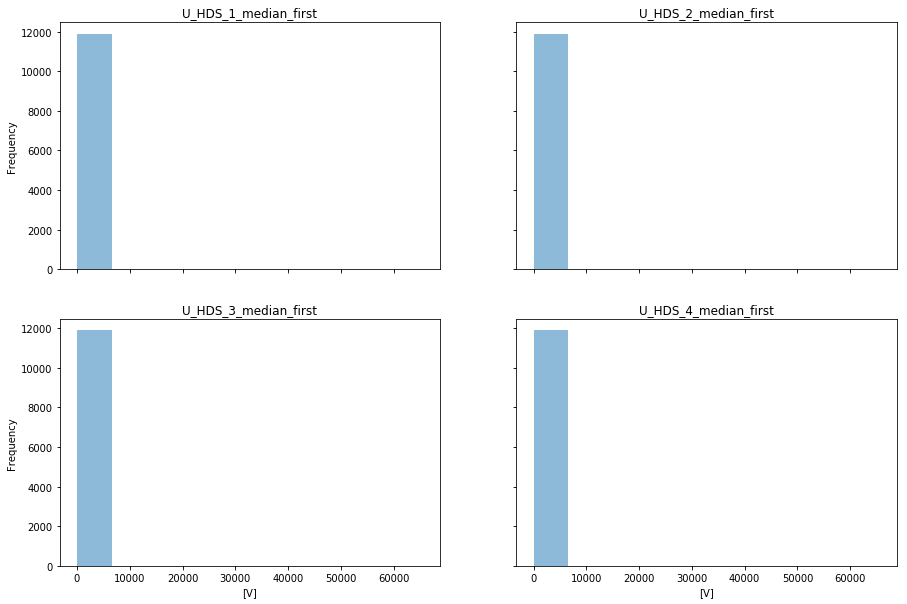

In [9]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
data['U_HDS_1_median_first'].plot.hist(bins=10, ax=ax[0,0], alpha=0.5, title = "U_HDS_1_median_first").set(xlabel="[V]")
data['U_HDS_2_median_first'].plot.hist(bins=10, ax=ax[0,1], alpha=0.5, title = "U_HDS_2_median_first").set(xlabel="[V]")
data['U_HDS_3_median_first'].plot.hist(bins=10, ax=ax[1,0], alpha=0.5, title = "U_HDS_3_median_first").set(xlabel="[V]")
data['U_HDS_4_median_first'].plot.hist(bins=10, ax=ax[1,1], alpha=0.5, title = "U_HDS_4_median_first").set(xlabel="[V]")

## 2.2 Raw data - histograms of final voltage

[Text(0.5,0,'[V]')]

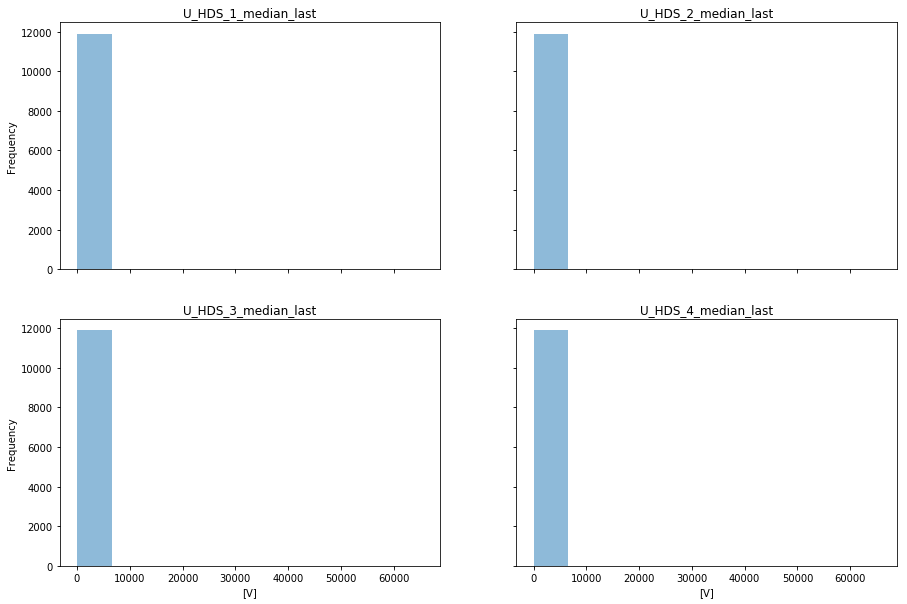

In [10]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
data['U_HDS_1_median_last'].plot.hist(bins=10, ax=ax[0,0], alpha=0.5, title = "U_HDS_1_median_last").set(xlabel="[V]")
data['U_HDS_2_median_last'].plot.hist(bins=10, ax=ax[0,1], alpha=0.5, title = "U_HDS_2_median_last").set(xlabel="[V]")
data['U_HDS_3_median_last'].plot.hist(bins=10, ax=ax[1,0], alpha=0.5, title = "U_HDS_3_median_last").set(xlabel="[V]")
data['U_HDS_4_median_last'].plot.hist(bins=10, ax=ax[1,1], alpha=0.5, title = "U_HDS_4_median_last").set(xlabel="[V]")

## 2.3 Raw data - filter out wrong measurements
- remove events with and voltages above 1500 V
- to do so, find an intersection of indices across all

In [11]:
uThresholdInVolts = 1500

In [12]:
def logicOperationOnIndices(df, signalNames, suffix, threshold, index, comparisonOperator, logicOperation):
    outputIndex = index
    for signalName in signalNames:
        signalNameSuffix = signalName + suffix
        comparisonResult = comparisonOperator(df[signalNameSuffix], threshold)
        foundIndicesZeroBased = np.where(comparisonResult)
        foundIndices = index[foundIndicesZeroBased]
        outputIndex = logicOperation(outputIndex, foundIndices)
    return outputIndex

## 2.4 Find events with too large voltage

In [13]:
union = []
union = logicOperationOnIndices(data, uNames, '_median_last', uThresholdInVolts, union, operator.le, np.union1d)
union = logicOperationOnIndices(data, uNames, '_median_first', uThresholdInVolts, union, operator.le, np.union1d)
print('There are {} events in {} with at least one starting and final voltage above {}'.\
      format(len(union), selectedYear, uThresholdInVolts))

There are 11885 events in 2015 with at least one starting and final voltage above 1500


In [14]:
missingDataIndices = data.index.isin(union)
filteredData = data.iloc[union]
missingData = data[~missingDataIndices]

In [15]:
print('There are {} events with at least one missing signal.'.format(len(missingData)))
missingData.head()

There are 11 events with at least one missing signal.


timestamp  I_HDS_4_min   I_HDS_3_min   I_HDS_2_min  \
0     1420114106613000000      65535.0  65535.000000  65535.000000   
1     1420536812313000000      65535.0  65535.000000  65535.000000   
12    1420560946813000000      65535.0  65535.000000  65535.000000   
15    1420636639412000000      65535.0  65535.000000  65535.000000   
1335  1421833118813000000          0.0      0.003815      0.005722   

      I_HDS_1_min  U_HDS_4_min  U_HDS_3_min  U_HDS_2_min  U_HDS_1_min  \
0         65535.0      65535.0      65535.0      65535.0      65535.0   
1         65535.0      65535.0      65535.0      65535.0      65535.0   
12        65535.0      65535.0      65535.0      65535.0      65535.0   
15        65535.0      65535.0      65535.0      65535.0      65535.0   
1335          0.0          0.0          0.0          0.0          0.0   

      I_HDS_4_max     ...      I_HDS_3_median_last  I_HDS_2_median_last  \
0      65535.0000     ...                  65535.0              65535.0   
1      65535.0000     ...                  65535.0              65535.0   
12     65535.0000     ...                  65535.0              65535.0   
15     65535.0000     ...                  65535.0              65535.0   
1335      72.7902     ...                      NaN                  NaN   

      I_HDS_1_median_last  U_HDS_4_median_last  U_HDS_3_median_last  \
0                 65535.0              65535.0              65535.0   
1                 65535.0              65535.0              65535.0   
12                65535.0              65535.0              65535.0   
15                65535.0              65535.0              65535.0   
1335                  NaN                  NaN                  NaN   

      U_HDS_2_median_last  U_HDS_1_median_last  RPTE.UA67.RB.A67:I_MEAS  \
0                 65535.0              65535.0                    -0.13   
1                 65535.0              65535.0                      NaN   
12                65535.0              65535.0                      NaN   
15                65535.0              65535.0                     0.02   
1335                  NaN                  NaN                      NaN   

      circuit         day  
0      RB.A67  2015-01-01  
1      RB.A67  2015-01-06  
12     RB.A67  2015-01-06  
15     RB.A67  2015-01-07  
1335   RB.A56  2015-01-21  

[5 rows x 77 columns]

<h1><center>3. Filtered Data</center></h1>
<img src = "figures/spurious_triggers.png" width=35%>

## 3.1 Filtered data - histograms of initial voltage

[Text(0.5,0,'[V]')]

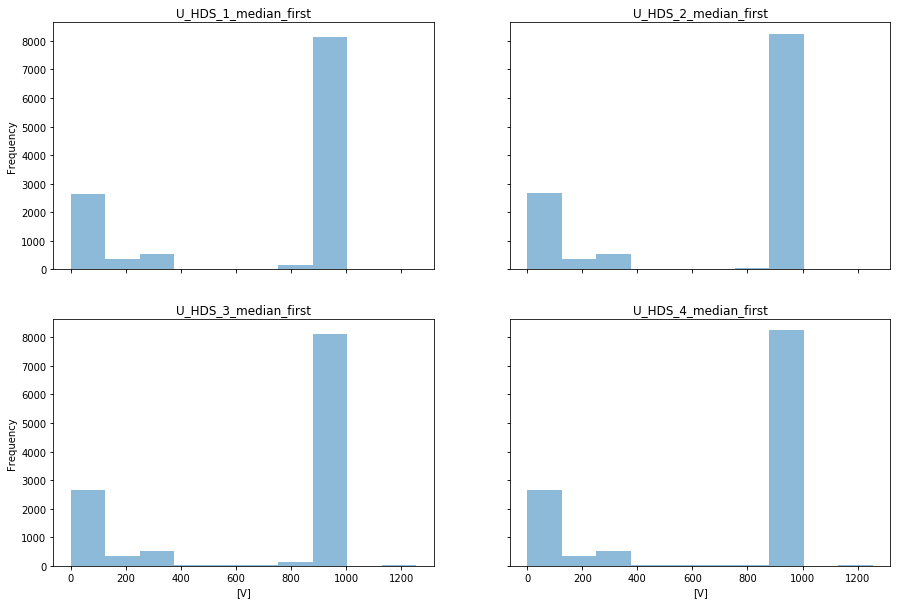

In [16]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
filteredData['U_HDS_1_median_first'].plot.hist(bins=10, ax=ax[0,0], alpha=0.5, title = "U_HDS_1_median_first").set(xlabel="[V]")
filteredData['U_HDS_2_median_first'].plot.hist(bins=10, ax=ax[0,1], alpha=0.5, title = "U_HDS_2_median_first").set(xlabel="[V]")
filteredData['U_HDS_3_median_first'].plot.hist(bins=10, ax=ax[1,0], alpha=0.5, title = "U_HDS_3_median_first").set(xlabel="[V]")
filteredData['U_HDS_4_median_first'].plot.hist(bins=10, ax=ax[1,1], alpha=0.5, title = "U_HDS_4_median_first").set(xlabel="[V]")

## 3.2 Filtered data - histograms of final voltage

[Text(0.5,0,'[V]')]

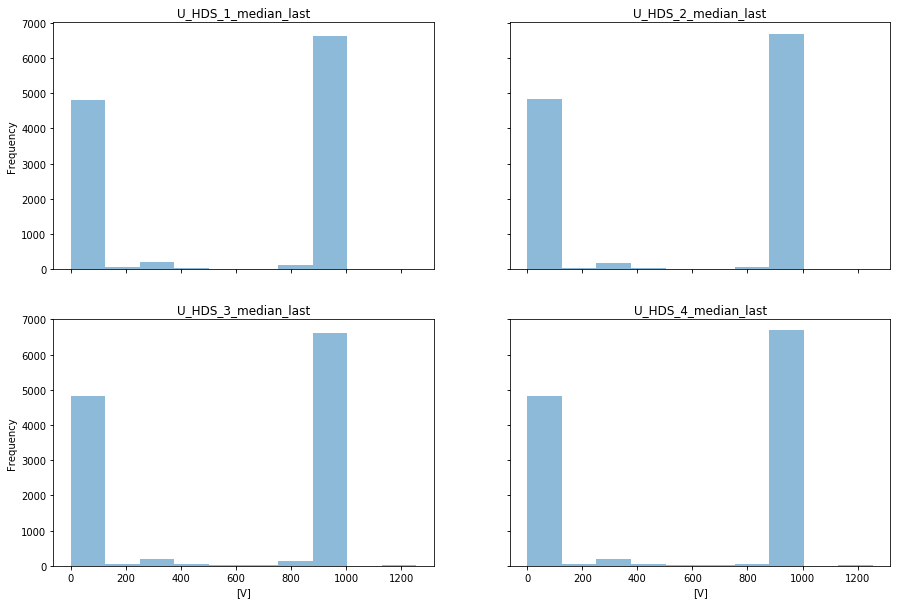

In [17]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
filteredData['U_HDS_1_median_last'].plot.hist(bins=10, ax=ax[0,0], alpha=0.5, title = "U_HDS_1_median_last").set(xlabel="[V]")
filteredData['U_HDS_2_median_last'].plot.hist(bins=10, ax=ax[0,1], alpha=0.5, title = "U_HDS_2_median_last").set(xlabel="[V]")
filteredData['U_HDS_3_median_last'].plot.hist(bins=10, ax=ax[1,0], alpha=0.5, title = "U_HDS_3_median_last").set(xlabel="[V]")
filteredData['U_HDS_4_median_last'].plot.hist(bins=10, ax=ax[1,1], alpha=0.5, title = "U_HDS_4_median_last").set(xlabel="[V]")

<h1><center>4. Discharges with initial voltage above 800 V and final below 200 V</center></h1>
<img src = "figures/full_discharge.png" width=35%>

In [18]:
uThresholdInitialInVolts = 800
uThresholdFinalInVolts = 200
intersection = filteredData.index
intersection = logicOperationOnIndices(filteredData, uNames, '_median_first', uThresholdInitialInVolts, intersection, operator.ge, np.intersect1d)
intersection = logicOperationOnIndices(filteredData, uNames, '_median_last', uThresholdFinalInVolts, intersection, operator.le, np.intersect1d)
print('There are {} events in {} with initial voltage above {} and final voltage below {}'.\
      format(len(union), selectedYear, uThresholdInitialInVolts, uThresholdFinalInVolts))

There are 11885 events in 2015 with initial voltage above 800 and final voltage below 200


In [19]:
dischargeIndices = filteredData.index.isin(intersection)
dischargeData = filteredData.iloc[intersection]

## 4.1 Full discharge - Histograms of initial voltage

[Text(0.5,0,'[V]')]

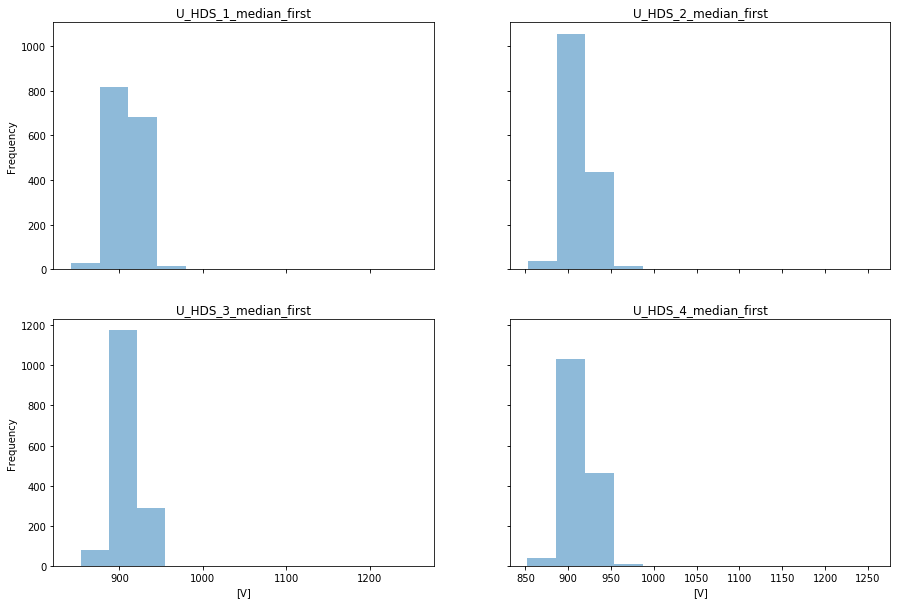

In [20]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
dischargeData['U_HDS_1_median_first'].plot.hist(bins=12, ax=ax[0,0], alpha=0.5, title = "U_HDS_1_median_first").set(xlabel="[V]")
dischargeData['U_HDS_2_median_first'].plot.hist(bins=12, ax=ax[0,1], alpha=0.5, title = "U_HDS_2_median_first").set(xlabel="[V]")
dischargeData['U_HDS_3_median_first'].plot.hist(bins=12, ax=ax[1,0], alpha=0.5, title = "U_HDS_3_median_first").set(xlabel="[V]")
dischargeData['U_HDS_4_median_first'].plot.hist(bins=12, ax=ax[1,1], alpha=0.5, title = "U_HDS_4_median_first").set(xlabel="[V]")

## 4.2 Full discharge - Histograms of final voltage

[Text(0.5,0,'[V]')]

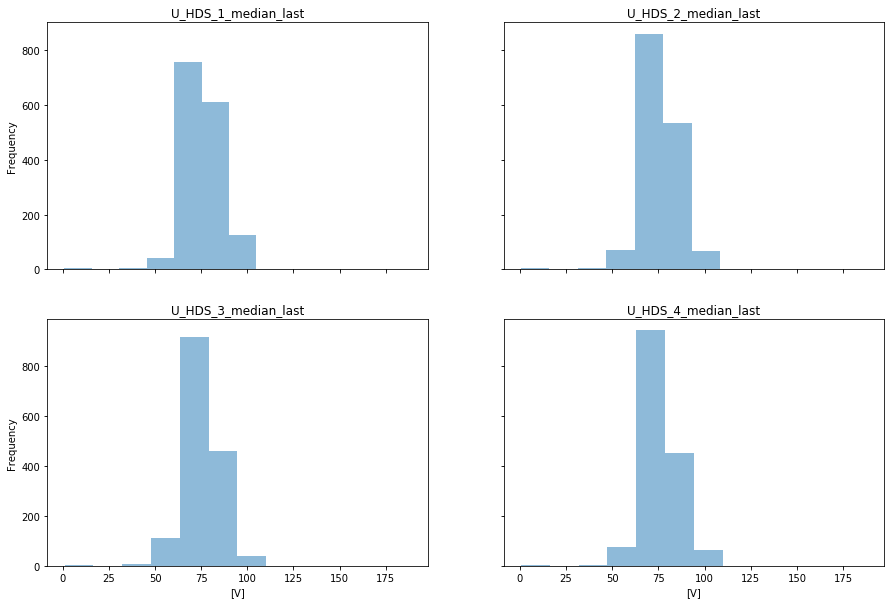

In [21]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
dischargeData['U_HDS_1_median_last'].plot.hist(bins=12, ax=ax[0,0], alpha=0.5, title = "U_HDS_1_median_last").set(xlabel="[V]")
dischargeData['U_HDS_2_median_last'].plot.hist(bins=12, ax=ax[0,1], alpha=0.5, title = "U_HDS_2_median_last").set(xlabel="[V]")
dischargeData['U_HDS_3_median_last'].plot.hist(bins=12, ax=ax[1,0], alpha=0.5, title = "U_HDS_3_median_last").set(xlabel="[V]")
dischargeData['U_HDS_4_median_last'].plot.hist(bins=12, ax=ax[1,1], alpha=0.5, title = "U_HDS_4_median_last").set(xlabel="[V]")

<h1><center>5. Let the data speak for itself!</center></h1>

## 5.1 How many quenches per day?

2015-02-18    162
2015-02-15    160
2015-02-10    158
2015-01-23    151
2015-01-20    147
2015-01-13     49
2015-03-21     28
2015-03-18     27
2015-03-13     25
2015-03-15     25
2015-03-14     21
2015-03-17     20
2015-03-10     20
2015-02-07     19
2015-02-11     19
2015-03-19     19
2015-03-20     19
2015-02-20     16
2015-02-16     16
2015-02-19     14
2015-03-09     13
2015-03-24     13
2015-03-25     13
2015-03-12     13
2015-02-06     13
2015-02-21     13
2015-03-26     12
2015-02-27     12
2015-02-08     12
2015-02-26     12
             ... 
2015-03-22     10
2015-03-02     10
2015-02-24      9
2015-04-01      9
2015-03-05      9
2015-03-01      9
2015-11-12      8
2015-02-25      8
2015-03-27      8
2015-01-18      7
2015-07-14      7
2015-06-11      7
2015-03-16      7
2015-04-03      6
2015-02-09      6
2015-02-23      6
2015-12-13      5
2015-10-01      5
2015-10-03      5
2015-02-22      5
2015-12-08      4
2015-02-28      4
2015-04-14      4
2015-09-14      4
2015-05-14

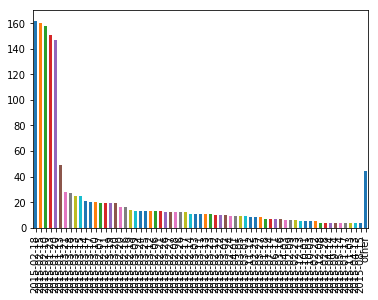

In [22]:
eventsPerDay = dischargeData['day'].value_counts()
threshold = 3
mask = eventsPerDay > threshold
tail_prob = eventsPerDay.loc[~mask].sum()
eventsPerDay = eventsPerDay.loc[mask]
eventsPerDay['other'] = tail_prob
print(eventsPerDay)
eventsPerDay.plot(kind='bar')

## 5.2 How many quenches per arc?

RB.A45    371
RB.A81    295
RB.A78    263
RB.A34    254
RB.A23    229
RB.A56     94
RB.A67     19
RB.A12     19
Name: circuit, dtype: int64


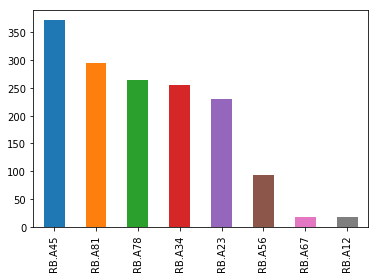

In [23]:
eventsPerArc = dischargeData['circuit'].value_counts()
print(eventsPerArc)
eventsPerArc.plot(kind='bar')

## 5.3 How many quenches per magnet?

In [24]:
eventsPerMagnet = dischargeData['magnetName'].value_counts()
eventsPerMagnet

B15R8    7
A21L5    7
A15R8    7
B21L5    6
C14R8    6
C20L5    6
B25L5    5
A34R7    5
B15L5    5
C22R4    5
C25L5    5
A25L5    5
C14L5    5
A15L5    5
B8L4     5
B22R4    4
A27L5    4
A22R4    4
A23R4    4
A33R7    4
A26L5    4
A20L5    4
A32R7    4
B34R4    4
A14R8    4
C33L1    4
B20L5    4
C34R7    4
C15R8    4
A29L4    4
        ..
A34R3    1
A21L8    1
B12R8    1
C16R8    1
B25L3    1
C27R8    1
C33R3    1
A12L8    1
A33L8    1
B20L2    1
A24R2    1
B15L4    1
A27R3    1
A14R4    1
C15L6    1
C14R4    1
B16R5    1
B19R7    1
C20R2    1
C27L4    1
A24R7    1
B25R3    1
C33L5    1
C31R2    1
C18L8    1
B25R2    1
B29L8    1
C19R4    1
B31R4    1
A12L4    1
Name: magnetName, Length: 869, dtype: int64

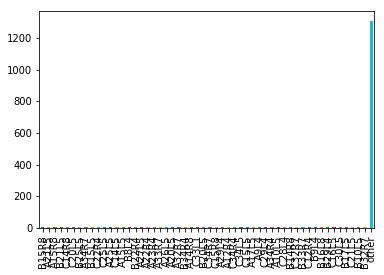

In [25]:
threshold = 3
mask = eventsPerMagnet > threshold
tail_prob = eventsPerMagnet.loc[~mask].sum()
eventsPerMagnet = eventsPerMagnet.loc[mask]
eventsPerMagnet['other'] = tail_prob
eventsPerMagnet.plot(kind='bar')

### 5.3.1 Full Data - Get all events for a given magnet

In [26]:
fullDataGivenMagnet = dischargeData.loc[dischargeData['magnetName'] == 'A21L5']
fullDataGivenMagnet

timestamp  I_HDS_4_min  I_HDS_3_min  I_HDS_2_min  \
5461   1424018679113000000     0.061037     1.842548     0.000000   
9672   1426220625990000000     0.011444     0.078203     0.019074   
9755   1426578060472000000     0.072481     0.078203     0.062944   
10030  1426780197472000000     0.066759     0.078203     0.000000   
10238  1426827296071000000     0.051500     0.078203     0.000000   
10859  1427142016960000000     0.061037     0.078203     0.051500   
10892  1427343695617000000     0.055315     0.078203     0.000000   

       I_HDS_1_min  U_HDS_4_min  U_HDS_3_min  U_HDS_2_min  U_HDS_1_min  \
5461      0.053407    25.970000    24.935032    25.318352    24.570877   
9672      0.074389    26.813305    25.912500    26.123327    25.605843   
9755      0.083926    26.679142    25.778337    25.989164    25.490847   
10030     0.082018    28.135761    27.119960    27.388287    26.774973   
10238     0.066759    26.142492    25.203356    25.395018    24.935032   
10859     0.083926    28.365755    27.330788    27.579947    26.966633   
10892     0.070574    26.238323    25.318352    25.510014    25.050028   

       I_HDS_4_max     ...      I_HDS_3_median_last  I_HDS_2_median_last  \
5461     98.353170     ...                 0.082018             0.083926   
9672     96.638420     ...                 0.082018             0.084879   
9755     95.183075     ...                 0.082018             0.083926   
10030    96.300810     ...                 0.081064             0.082018   
10238    95.005684     ...                 0.081064             0.084879   
10859    98.086136     ...                 0.081064             0.083926   
10892    99.617775     ...                 0.080111             0.083926   

       I_HDS_1_median_last  U_HDS_4_median_last  U_HDS_3_median_last  \
5461              0.085833            74.086369            78.015411   
9672              0.085833            78.389145            82.145691   
9755              0.085833            74.182198            77.651253   
10030             0.083926            72.486004            75.993393   
10238             0.084879            68.202393            71.326458   
10859             0.084879            72.696831            76.127552   
10892             0.085833            71.451035            74.613434   

       U_HDS_2_median_last  U_HDS_1_median_last  RPTE.UA67.RB.A67:I_MEAS  \
5461             77.804581            70.396904                     0.00   
9672             82.021114            75.035088                  2164.32   
9755             77.574589            71.048550                  6699.05   
10030            75.667568            69.371521                 10450.78   
10238            71.498951            65.327484                   357.23   
10859            75.840061            69.659012                 10836.50   
10892            74.728432            68.585709                  3490.40   

       circuit         day  
5461    RB.A45  2015-02-15  
9672    RB.A45  2015-03-13  
9755    RB.A45  2015-03-17  
10030   RB.A45  2015-03-19  
10238   RB.A45  2015-03-20  
10859   RB.A45  2015-03-23  
10892   RB.A45  2015-03-26  

[7 rows x 77 columns]

### 5.3.1 When did the quenches occur?

In [27]:
magnet = 'A21L5'
from ipywidgets import interact, interactive, fixed, interact_manual
def queryMagnet(k):
    system = metadata['system']
    className = metadata['className']
    uNames = metadata['uNames']
    iNames = metadata['iNames']
    timestamp = list(fullDataGivenMagnet['timestamp'])[k]
        
    print("Querying quench heater voltage and current for {} at {}, please wait...".format(magnet, timestamp))

    QhDischarge = Signal()
    for signalName in uNames+iNames:
        QhDischarge.read('pm', append=True, system=system, className=className, source=magnet, 
                              signalName=signalName, eventTime=int(timestamp))

    myDF = QhDischarge.get_synchronized_time_df()
    
    %matplotlib notebook
    fig, ax = plt.subplots(1, 2, figsize=(17, 5))
    myDF.filter(regex=("U_HDS_\d{1}")).plot(ax=ax[0]).set(xlabel="[s]", ylabel="[V]")
    if magnetType is "MB":
        myDF.filter(regex=("I_HDS_\d{1}")).plot(ax=ax[1]).set(xlabel="[s]", ylabel="[A]")
    
interactive_plot = interactive(queryMagnet, k=(0, fullDataGivenMagnet.shape[0]-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=3, description='k', max=6), Output()), _dom_classes=('widget-interact',)…

# Filter out PM events during HWC and operation
<img src = "figures/hwc_operation.png" width=35%>

- at 0 current: QH powering during HWC
- at nominal current: QH powering during stable beams
- at intermediate currents: all other cases

# For an operational QH discharges calculate - See Christophs presentation!
<img src = "figures/characteristic_time.png" width=35%>

- time constant for voltage 
- time constant for current (MB)